## Dataset - Movielens data
https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import io
import os
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [5]:
plt.style.use('ggplot')

In [6]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

In [7]:
RANDOM_STATE = 1
set_random_seed(RANDOM_STATE)

In [8]:
def try_download(url, download_path):
    archive_name = url.split('/')[-1]
    folder_name, _ = os.path.splitext(archive_name)
    
    try:
        r = urlopen(url)
    except URLError as e:
        print('Cannot download the data. Error: %s' % s)
        return 

    assert r.status == 200
    data = r.read()

    with zipfile.ZipFile(io.BytesIO(data)) as arch:
        arch.extractall(download_path)
        
    print('The archive is extracted into folder: %s' % download_path)

In [9]:
def read_data(path):
    files = {}
    for filename in path.glob('*'):
        if filename.suffix == '.csv':
            files[filename.stem] = pd.read_csv(filename)
        elif filename.suffix == '.dat':
            if filename.stem == 'ratings':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
            else:
                columns = ['movieId', 'title', 'genres']
            data = pd.read_csv(filename, sep='::', names=columns, engine='python')
            files[filename.stem] = data
    return files['ratings'], files['movies']

In [10]:
# pick any other dataset instead
archive_url = f'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
download_path = '/Users/varunn/Documents/NLP-data'

In [14]:
try_download(archive_url, download_path)

The archive is extracted into folder: /Users/varunn/Documents/NLP-data


In [15]:
!ls -l $download_path

total 62528
drwxr-xr-x  3 vnathan  staff       102 Feb  4 23:17 MNLI
drwxr-xr-x  3 vnathan  staff       102 Apr  2  2019 MRPC
-rw-r--r--  1 vnathan  staff       217 Mar 22  2019 checkpoint
-rw-r--r--  1 vnathan  staff    472760 Mar 22  2019 embedding_intent_classifier_exampledataset.ckpt.data-00000-of-00001
-rw-r--r--  1 vnathan  staff       915 Mar 22  2019 embedding_intent_classifier_exampledataset.ckpt.index
-rw-r--r--  1 vnathan  staff    168005 Mar 22  2019 embedding_intent_classifier_exampledataset.ckpt.meta
-rw-r--r--  1 vnathan  staff       229 Mar 22  2019 embedding_intent_classifier_exampledataset_encoded_all_intents.pkl
-rw-r--r--  1 vnathan  staff        63 Mar 22  2019 embedding_intent_classifier_exampledataset_inv_intent_dict.pkl
drwxr-xr-x  6 vnathan  staff       204 May 15 12:11 ml-1m
drwxr-xr-x  7 vnathan  staff       238 May 15 12:03 ml-latest-small
-rw-r--r--  1 vnathan  staff  31344132 Jan  3  2019 text8.zip
-rw-r--r--  1 vnathan  staff       568 Mar 25  2019 vocabu

In [11]:
# pick one of the available folders
ratings, movies = read_data(Path(os.path.join(download_path, 'ml-1m')))

In [12]:
print(ratings.shape)
ratings.head()

(1000209, 4)


,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [13]:
print(movies.shape)
movies.head()

(3883, 3)


,movieId,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [14]:
def tabular_preview(ratings, n=15):
    """Creates a cross-tabular view of users vs movies."""
    
    user_groups = ratings.groupby('userId')['rating'].count()
    top_users = user_groups.sort_values(ascending=False)[:15]

    movie_groups = ratings.groupby('movieId')['rating'].count()
    top_movies = movie_groups.sort_values(ascending=False)[:15]

    top = (
        ratings.
        join(top_users, rsuffix='_r', how='inner', on='userId').
        join(top_movies, rsuffix='_r', how='inner', on='movieId'))

    return pd.crosstab(top.userId, top.movieId, top.rating,
                       aggfunc=np.sum)

In [15]:
tabular_preview(ratings, movies)

movieId,110,260,480,589,593,608,1196,1198,1210,1270,1580,2028,2571,2762,2858
userId,,,,,,,,,,,,,,,
889,4.0,4.0,3.0,5.0,5.0,4.0,4.0,NaN,3.0,4.0,3.0,3.0,5.0,NaN,2.0
1015,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,4.0
1150,2.0,5.0,NaN,2.0,3.0,5.0,4.0,2.0,3.0,2.0,2.0,2.0,1.0,2.0,4.0
1181,3.0,4.0,2.0,5.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,5.0,4.0,3.0
1449,3.0,3.0,2.0,2.0,5.0,5.0,3.0,4.0,2.0,2.0,4.0,3.0,4.0,4.0,4.0
1680,1.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,4.0,5.0,3.0,5.0,5.0
1941,5.0,5.0,5.0,3.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,3.0,5.0,1.0
1980,4.0,4.0,4.0,4.0,5.0,5.0,4.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0
2063,5.0,4.0,4.0,2.0,5.0,2.0,4.0,4.0,4.0,4.0,3.0,2.0,5.0,4.0,5.0


In [16]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()
    
    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)
    
    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)
    
    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]
    
    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

In [17]:
(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

Embeddings: 6040 users, 3706 movies
Dataset shape: (1000209, 2)
Target shape: (1000209,)


In [18]:
X.head()

,user_id,movie_id
0,0,0
1,0,1
2,0,2
3,0,3
4,0,4


In [19]:
class ReviewsIterator:
    
    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
            
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0
        
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [20]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in ReviewsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [21]:
for x_batch, y_batch in batches(X, y, bs=4):
    print(x_batch)
    print(y_batch)
    break

tensor([[3808, 2234],
        [1388,  143],
        [4509,  849],
        [1016, 2393]])
tensor([[4.],
        [4.],
        [2.],
        [3.]])


In [22]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [23]:
EmbeddingNet(n, m, n_factors=150, hidden=100, dropouts=0.5)

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=100, out_features=1, bias=True)
)

In [24]:
EmbeddingNet(n, m, n_factors=150, hidden=[100, 200, 300], dropouts=[0.25, 0.5])

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.02, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=100, out_features=200, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=200, out_features=300, bias=True)
    (7): ReLU()
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [25]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [26]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [27]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(math.pi*t/t_max))/2
    
    return scheduler

In [28]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

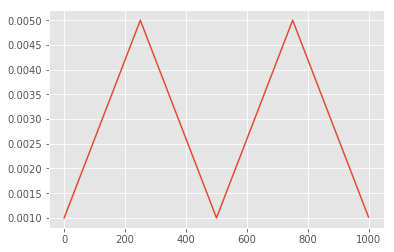

In [29]:
plot_lr(triangular(250, 0.005))

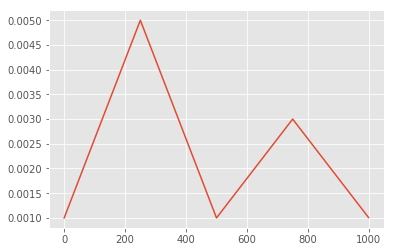

In [30]:
plot_lr(triangular(250, 0.005, 'triangular2'))

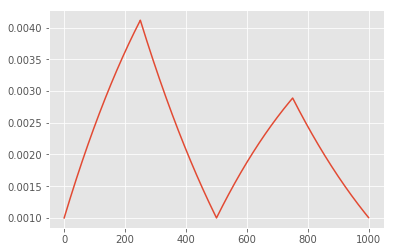

In [31]:
plot_lr(triangular(250, 0.005, 'exp_range', gamma=0.999))

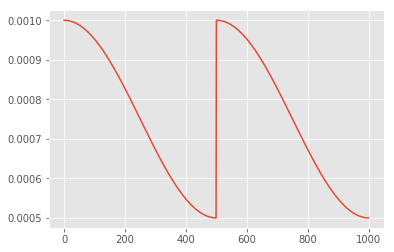

In [32]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

### Training Loop

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid)}

In [34]:
dataset_sizes

{'train': 800167, 'val': 200042}

In [35]:
minmax = (float(ratings.rating.min()),
          float(ratings.rating.max()))
minmax

(1.0, 5.0)

In [36]:
net = EmbeddingNet(
    n_users=n, n_movies=m, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [37]:
net

EmbeddingNet(
  (u): Embedding(6040, 150)
  (m): Embedding(3706, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [38]:
lr = 1e-3
wd = 1e-5
bs = 2000
n_epochs = 100
patience = 10
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))
scheduler = CyclicLR(optimizer, cosine(t_max=iterations_per_epoch * 2,
                                       eta_min=lr/10))

for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}
    
    for phase in ('train', 'val'):
        training = phase == 'train'
        running_loss = 0.0
        n_batches = 0
        
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
        
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
                loss = criterion(outputs, y_batch)
                print(loss)
                
                # don't update weights and rates when in 'val' phase
                if training:
                    scheduler.step()
                    loss.backward()
                    optimizer.step()
                    lr_history.extend(scheduler.get_lr())
                    
            running_loss += loss.item()
            
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
                
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

tensor(3148.7520, grad_fn=<MseLossBackward>)
tensor(2555.7461, grad_fn=<MseLossBackward>)


/Users/varunn/.virtualenvs/rasa/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


tensor(2552.3127, grad_fn=<MseLossBackward>)
tensor(2681.3884, grad_fn=<MseLossBackward>)
tensor(2731.8931, grad_fn=<MseLossBackward>)
tensor(2464.6257, grad_fn=<MseLossBackward>)
tensor(2398.1047, grad_fn=<MseLossBackward>)
tensor(2377.0625, grad_fn=<MseLossBackward>)
tensor(2518.9373, grad_fn=<MseLossBackward>)
tensor(2505.8223, grad_fn=<MseLossBackward>)
tensor(2606.1819, grad_fn=<MseLossBackward>)
tensor(2526.0781, grad_fn=<MseLossBackward>)
tensor(2594.4585, grad_fn=<MseLossBackward>)
tensor(2436.1130, grad_fn=<MseLossBackward>)
tensor(2404.7439, grad_fn=<MseLossBackward>)
tensor(2369.5781, grad_fn=<MseLossBackward>)
tensor(2433.4915, grad_fn=<MseLossBackward>)
tensor(2330.8042, grad_fn=<MseLossBackward>)
tensor(2303.6816, grad_fn=<MseLossBackward>)
tensor(2431.4692, grad_fn=<MseLossBackward>)
tensor(2283.0544, grad_fn=<MseLossBackward>)
tensor(2445.7249, grad_fn=<MseLossBackward>)
tensor(2152.8601, grad_fn=<MseLossBackward>)
tensor(2339.1650, grad_fn=<MseLossBackward>)
tensor(211

tensor(1802.4431, grad_fn=<MseLossBackward>)
tensor(1666.2184, grad_fn=<MseLossBackward>)
tensor(1771.3256, grad_fn=<MseLossBackward>)
tensor(1762.9574, grad_fn=<MseLossBackward>)
tensor(1756.3361, grad_fn=<MseLossBackward>)
tensor(1683.3010, grad_fn=<MseLossBackward>)
tensor(1692.4410, grad_fn=<MseLossBackward>)
tensor(1723.8469, grad_fn=<MseLossBackward>)
tensor(1669.2028, grad_fn=<MseLossBackward>)
tensor(1709.5653, grad_fn=<MseLossBackward>)
tensor(1754.6992, grad_fn=<MseLossBackward>)
tensor(1665.8644, grad_fn=<MseLossBackward>)
tensor(1725.8434, grad_fn=<MseLossBackward>)
tensor(1664.6660, grad_fn=<MseLossBackward>)
tensor(1807.9838, grad_fn=<MseLossBackward>)
tensor(1695.5953, grad_fn=<MseLossBackward>)
tensor(1646.2535, grad_fn=<MseLossBackward>)
tensor(1656.5924, grad_fn=<MseLossBackward>)
tensor(1684.3811, grad_fn=<MseLossBackward>)
tensor(1704.9347, grad_fn=<MseLossBackward>)
tensor(1735.1617, grad_fn=<MseLossBackward>)
tensor(1723.7136, grad_fn=<MseLossBackward>)
tensor(170

tensor(1707.5632, grad_fn=<MseLossBackward>)
tensor(1585.8671, grad_fn=<MseLossBackward>)
tensor(1608.0930, grad_fn=<MseLossBackward>)
tensor(1677.2140, grad_fn=<MseLossBackward>)
tensor(1613.2936, grad_fn=<MseLossBackward>)
tensor(1521.3264, grad_fn=<MseLossBackward>)
tensor(1661.1173, grad_fn=<MseLossBackward>)
tensor(1626.5718, grad_fn=<MseLossBackward>)
tensor(1839.2632, grad_fn=<MseLossBackward>)
tensor(1694.6663, grad_fn=<MseLossBackward>)
tensor(1675.9546, grad_fn=<MseLossBackward>)
tensor(1651.1442, grad_fn=<MseLossBackward>)
tensor(1614.9432, grad_fn=<MseLossBackward>)
tensor(1611.1829, grad_fn=<MseLossBackward>)
tensor(1718.8065, grad_fn=<MseLossBackward>)
tensor(1604.6656, grad_fn=<MseLossBackward>)
tensor(1642.3223, grad_fn=<MseLossBackward>)
tensor(1591.7050, grad_fn=<MseLossBackward>)
tensor(1695.2704, grad_fn=<MseLossBackward>)
tensor(1578.3879, grad_fn=<MseLossBackward>)
tensor(1703.2748, grad_fn=<MseLossBackward>)
tensor(1649.8302, grad_fn=<MseLossBackward>)
tensor(167

tensor(1599.7976, grad_fn=<MseLossBackward>)
tensor(1602.1539, grad_fn=<MseLossBackward>)
tensor(1634.7675, grad_fn=<MseLossBackward>)
tensor(1685.2021, grad_fn=<MseLossBackward>)
tensor(1591.9066, grad_fn=<MseLossBackward>)
tensor(1539.4634, grad_fn=<MseLossBackward>)
tensor(1569.5820, grad_fn=<MseLossBackward>)
tensor(1620.1078, grad_fn=<MseLossBackward>)
tensor(1557.4753, grad_fn=<MseLossBackward>)
tensor(1617.5555, grad_fn=<MseLossBackward>)
tensor(1591.5442, grad_fn=<MseLossBackward>)
tensor(1648.0376, grad_fn=<MseLossBackward>)
tensor(1578.5220, grad_fn=<MseLossBackward>)
tensor(1639.8181, grad_fn=<MseLossBackward>)
tensor(1549.7565, grad_fn=<MseLossBackward>)
tensor(1647.7009, grad_fn=<MseLossBackward>)
tensor(1520.8254, grad_fn=<MseLossBackward>)
tensor(1433.1162, grad_fn=<MseLossBackward>)
tensor(1521.5461, grad_fn=<MseLossBackward>)
tensor(1587.6735, grad_fn=<MseLossBackward>)
tensor(1655.5051, grad_fn=<MseLossBackward>)
tensor(1657.2467, grad_fn=<MseLossBackward>)
tensor(163

KeyboardInterrupt: 

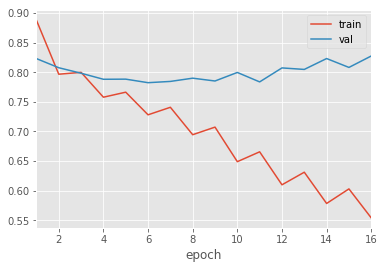

In [71]:
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

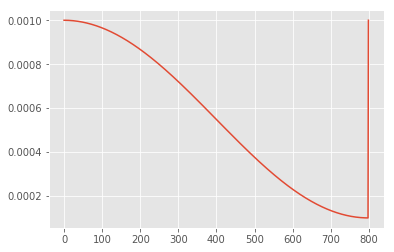

In [72]:
_ = plt.plot(lr_history[:2*iterations_per_epoch])

In [73]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [75]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [76]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 0.8851


In [77]:
with open(os.path.join(download_path, 'ml-1m/pytorch_model_best.weights'),
          'wb') as file:
    pickle.dump(best_weights, file)

### Embeddings Visualization

In [78]:
from sklearn.decomposition import PCA

In [80]:
with open(os.path.join(download_path, 'ml-1m/pytorch_model_best.weights'),
          'rb') as file:
    best_weights = pickle.load(file)
net.load_state_dict(best_weights)

<All keys matched successfully>

In [81]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [82]:
_, _, (user_id_map, movie_id_map) = create_dataset(ratings)
embed_to_original = {v: k for k, v in movie_id_map.items()}
popular_movies = ratings.groupby('movieId').movieId.count().sort_values(
    ascending=False).values[:1000]

In [86]:
embed = to_numpy(net.m.weight.data)
pca = PCA(n_components=5)
components = pca.fit(embed[popular_movies].T).components_
print(components.shape)
components

(5, 1000)


array([[ 0.00929549, -0.044062  , -0.05351381, ..., -0.01257454,
        -0.01257454, -0.01257454],
       [-0.03120749,  0.00266833, -0.03209128, ...,  0.02730897,
         0.02730897,  0.02730897],
       [-0.02876042,  0.05175858,  0.06533601, ..., -0.04921564,
        -0.04921564, -0.04921564],
       [ 0.015285  , -0.0116873 , -0.03953724, ...,  0.03325929,
         0.03325929,  0.03325929],
       [-0.03483692,  0.00106709, -0.0361088 , ..., -0.00689152,
        -0.00689152, -0.00689152]], dtype=float32)

In [87]:
components_df = pd.DataFrame(components.T, columns=[f'fc{i}' for i in range(pca.n_components_)])
movie_ids = [embed_to_original[idx] for idx in components_df.index]
meta = movies.set_index('movieId')
components_df['movie_id'] = movie_ids
components_df['title'] = meta.loc[movie_ids].title.values
components_df['genres'] = meta.loc[movie_ids].genres.values

In [88]:
components_df.sample(4)

,fc0,fc1,fc2,fc3,fc4,movie_id,title,genres
24,-0.002523,-0.009493,-0.039207,-0.011832,0.009102,2340,Meet Joe Black (1998),Romance
36,0.006173,-0.015068,-0.051067,-0.008499,-0.013557,1836,"Last Days of Disco, The (1998)",Drama
615,-0.030380,0.027228,-0.056958,0.017534,0.013603,2662,"War of the Worlds, The (1953)",Action|Sci-Fi|War
342,0.026507,0.063297,-0.017463,0.075442,0.048534,1449,Waiting for Guffman (1996),Comedy


In [89]:
def plot_components(components, component, ascending=False):
    fig, ax = plt.subplots(figsize=(18, 12))
    
    subset = components.sort_values(by=component, ascending=ascending).iloc[:12]
    columns = components_df.columns
    features = columns[columns.str.startswith('fc')].tolist()
    
    fc = subset[features]
    titles = ['\n'.join(wrap(t, width=10)) for t in subset.title]
    genres = subset.genres.str.replace('|', '\n')
    labels = [f'{t}\n\n{g}' for t, g in zip(titles, genres)]
    
    fc.plot(ax=ax, kind='bar')
    y_ticks = [f'{t:2.2f}' for t in ax.get_yticks()]
    ax.set_xticklabels(labels, rotation=0, fontsize=14)
    ax.set_yticklabels(y_ticks, fontsize=14)
    ax.legend(loc='best', fontsize=14)
    
    plot_title = f"Movies with {['highest', 'lowest'][ascending]} '{component}' component values" 
    ax.set_title(plot_title, fontsize=20)

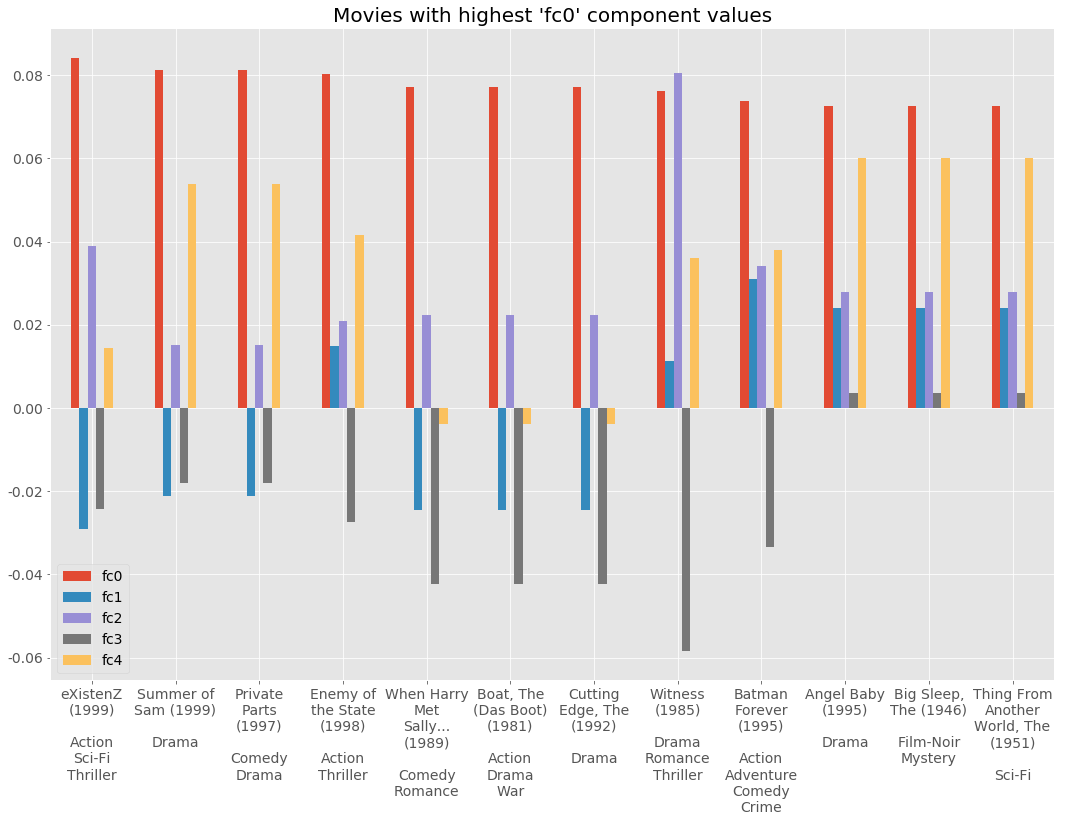

In [90]:
plot_components(components_df, 'fc0', ascending=False)

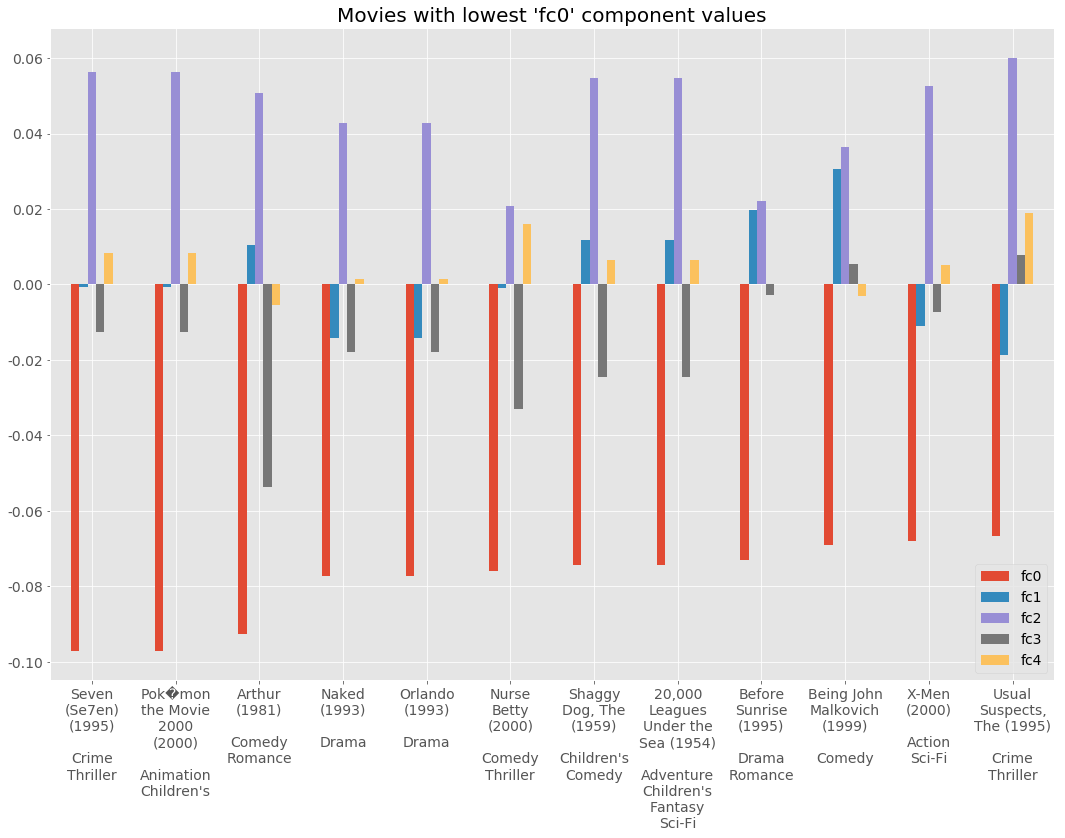

In [91]:
plot_components(components_df, 'fc0', ascending=True)

## Matrix Factorization in pytorch

In [92]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

In [93]:
class MatrixFactorization(nn.Module):
    
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.item_factors = nn.Embedding(n_items, n_factors)
        
    def forward(self, user, item):
        return (self.user_factors(user)*self.item_factors(item)).sum(1)
    
    def predict(self, user, item):
        return self.forward(user, item)

In [94]:
print('num users: ', n)
print('num movies: ', m)

num users:  6040
num movies:  3706


In [95]:
model = MatrixFactorization(n_users=n, n_items=m, n_factors=150)

In [96]:
model

MatrixFactorization(
  (user_factors): Embedding(6040, 150)
  (item_factors): Embedding(3706, 150)
)

In [102]:
x_train, y_train = datasets['train']
print(x_train.shape)
print(y_train.shape)
print(type(x_train))
print(x_train.head())

x_val, y_val = datasets['val']
print(x_val.shape)
print(y_val.shape)
print(type(x_val))
print(x_val.head())

(800167, 2)
(800167,)
<class 'pandas.core.frame.DataFrame'>
        user_id  movie_id
529184     3270      1925
341591     2011       579
470922     2898      1497
630004     3807       737
131938      853       536
(200042, 2)
(200042,)
<class 'pandas.core.frame.DataFrame'>
        user_id  movie_id
630120     3808      2234
229398     1388       143
758377     4509       849
159240     1016      2393
254252     1545       883


In [107]:
count = 0
for row in X.itertuples():
    print(row, '\t', row[1], '\t', row[2])
    if count > 2:
        break
    count += 1

Pandas(Index=0, user_id=0, movie_id=0) 	 0 	 0
Pandas(Index=1, user_id=0, movie_id=1) 	 0 	 1
Pandas(Index=2, user_id=0, movie_id=2) 	 0 	 2
Pandas(Index=3, user_id=0, movie_id=3) 	 0 	 3


In [125]:
import os
import requests
import zipfile

import numpy as np
import pandas as pd
import scipy.sparse as sp

"""
Shamelessly stolen from
https://github.com/maciejkula/triplet_recommendations_keras
"""


def train_test_split(interactions, n=10):
    """
    Split an interactions matrix into training and test sets.
    Parameters
    ----------
    interactions : np.ndarray
    n : int (default=10)
        Number of items to select / row to place into test.
    Returns
    -------
    train : np.ndarray
    test : np.ndarray
    """
    test = np.zeros(interactions.shape)
    train = interactions.copy()
    for user in range(interactions.shape[0]):
        if interactions[user, :].nonzero()[0].shape[0] > n:
            test_interactions = np.random.choice(interactions[user, :].nonzero()[0],
                                                 size=n,
                                                 replace=False)
            train[user, test_interactions] = 0.
            test[user, test_interactions] = interactions[user, test_interactions]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test


def _get_data_path():
    """
    Get path to the movielens dataset file.
    """
    data_path = os.path.join(os.path.dirname(os.path.abspath(__file__)),
                        'data')
    if not os.path.exists(data_path):
        print('Making data path')
        os.mkdir(data_path)
    return data_path


def _download_movielens(dest_path):
    """
    Download the dataset.
    """

    url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
    req = requests.get(url, stream=True)

    print('Downloading MovieLens data')

    with open(os.path.join(dest_path, 'ml-100k.zip'), 'wb') as fd:
        for chunk in req.iter_content(chunk_size=None):
            fd.write(chunk)

    with zipfile.ZipFile(os.path.join(dest_path, 'ml-100k.zip'), 'r') as z:
        z.extractall(dest_path)


def get_movielens_interactions(ratings):

    user_ids = ratings.userId.unique()
    item_ids = ratings.movieId.unique()
    
    n_users, n_items = user_ids.shape[0], item_ids.shape[0]
    
    user2index = {value: i for i, value in enumerate(user_ids)}
    item2index = {value: i for i, value in enumerate(item_ids)}

    interactions = np.zeros((n_users, n_items))
    for row in ratings.itertuples():
        interactions[user2index[row[1]], item2index[row[2]]] = row[3]
    return interactions, user2index, item2index


def get_movielens_train_test_split(ratings, implicit=False):
    interactions, user2index, item2index = get_movielens_interactions(
        ratings)
    if implicit:
        interactions = (interactions >= 4).astype(np.float32)
    train, test = train_test_split(interactions)
    train = sp.coo_matrix(train)
    test = sp.coo_matrix(test)
    return train, test, user2index, item2index

In [126]:
train, test, user2index, item2index = get_movielens_train_test_split(
    ratings)

In [127]:
print(train.shape)
print(test.shape)

(6040, 3706)
(6040, 3706)


In [128]:
train

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 939809 stored elements in COOrdinate format>

In [129]:
test

<6040x3706 sparse matrix of type '<class 'numpy.float64'>'
	with 60400 stored elements in COOrdinate format>

In [131]:
test.astype(np.float32).tocoo().nnz

60400

In [132]:
test.nnz

60400

In [134]:
test.row[0], test.col[0], test.data[0]

(0, 0, 5.0)